### Create aligned, stacked tifs from MicaSense image captures

This script should be used for one station at a time. 

Metadata is saved as log.csv


In [7]:
import os
from micasense import imageset as imageset
from micasense import capture as capture
from micasense import image as image
from micasense import metadata as metadata
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Load in Lsky and Lt captures
***Must change 'i=' to run script on each station*** <br>


0002SET
# of Lsky captures = 3
# of main captures =  87
Altitude cutoff = 14.761
Mean altitude = 33.495
# of flight captures = 31


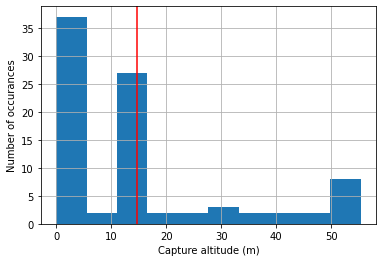

In [10]:
station_data = pd.read_excel(os.path.join('F:/', 'Micasense_WQ', 'station_data.xlsx'), index_col=False)
i=17

date = station_data['Date'][i]
mica_dir = station_data['MicaSense dir'][i]
print(mica_dir)

imagePath = os.path.join('S:/', 'Micasense_WQ', date, mica_dir, '000')

#load Lsky imageset
Lsky_images_dir = os.path.join(imagePath, 'Lsky')
Lsky_imgset = imageset.ImageSet.from_directory(Lsky_images_dir)
Lsky_captures = Lsky_imgset.captures
print('# of Lsky captures =', len(Lsky_captures))

#load main dataset
main_images_dir = os.path.join(imagePath, 'main')
main_imgset = imageset.ImageSet.from_directory(main_images_dir)
main_captures = main_imgset.captures
print('# of main captures = ', len(main_captures))

#load flight captures
data, columns = main_imgset.as_nested_lists()
df = pd.DataFrame.from_records(data, index='timestamp', columns=columns)

# plot the histogram of the altitude data
df.altitude.hist();
plt.xlabel('Capture altitude (m)');
plt.ylabel('Number of occurances');

#using top 30 highest altitude captures
top_30 = df.nlargest(30, 'altitude')
top_30_cutoff = top_30.altitude.min()
print('Altitude cutoff =', top_30_cutoff)
print('Mean altitude =', top_30.altitude.mean())

#add cutoff line to histrogram
plt.axvline(x=top_30_cutoff,c='r');

#declare 30 flight captures
flight = df.altitude>=top_30_cutoff
flight_idx = np.arange(len(flight))[flight]
flight_captures = np.array(main_imgset.captures)[flight_idx] 
print('# of flight captures =', len(flight_captures))


### Create new directories and save aligned, stacked Lsky tifs 

This code was taken from provided MicaSense scripts: Batch Processing.ipynb from https://github.com/micasense/imageprocessing

In [3]:
#create directory paths
outputPath = os.path.join(imagePath, 'Lsky_stacks')
thumbnailPath = os.path.join(imagePath, 'Lsky_thumbnails')

overwrite = True # can be set to set to False to continue interrupted processing
generateThumbnails = True

if not os.path.exists(outputPath):
    os.makedirs(outputPath)
if generateThumbnails and not os.path.exists(thumbnailPath):
    os.makedirs(thumbnailPath)

panelNames = None
useDLS = False

#loop through each flight capture to align and save as stacked tif 
for i,capture in enumerate(Lsky_captures):
    outputFilename = capture.uuid+'.tif'
    thumbnailFilename = capture.uuid+'.jpg'
    fullOutputPath = os.path.join(outputPath, outputFilename)
    fullThumbnailPath= os.path.join(thumbnailPath, thumbnailFilename)
    if (not os.path.exists(fullOutputPath)) or overwrite:
        if(len(capture.images) == len(Lsky_captures[0].images)):
            align = capture.create_aligned_capture(irradiance_list=None, warp_matrices=None, img_type='radiance')
            stack = capture.save_capture_as_stack(fullOutputPath, sort_by_wavelength = True)
            if generateThumbnails:
                capture.save_capture_as_rgb(fullThumbnailPath)
    capture.clear_image_data()


"\n#create directory paths\noutputPath = os.path.join(imagePath, 'Lsky_stacks')\nthumbnailPath = os.path.join(imagePath, 'Lsky_thumbnails')\n\noverwrite = True # can be set to set to False to continue interrupted processing\ngenerateThumbnails = True\n\nif not os.path.exists(outputPath):\n    os.makedirs(outputPath)\nif generateThumbnails and not os.path.exists(thumbnailPath):\n    os.makedirs(thumbnailPath)\n\npanelNames = None\nuseDLS = False\n\n#loop through each flight capture to align and save as stacked tif \nfor i,capture in enumerate(Lsky_captures):\n    outputFilename = capture.uuid+'.tif'\n    thumbnailFilename = capture.uuid+'.jpg'\n    fullOutputPath = os.path.join(outputPath, outputFilename)\n    fullThumbnailPath= os.path.join(thumbnailPath, thumbnailFilename)\n    if (not os.path.exists(fullOutputPath)) or overwrite:\n        if(len(capture.images) == len(Lsky_captures[0].images)):\n            align = capture.create_aligned_capture(irradiance_list=None, warp_matrices=No

### Extract metadata and save as log.csv

This code was taken from provided MicaSense scripts: Batch Processing.ipynb from https://github.com/micasense/imageprocessing

In [4]:
#extract metadata from captures list and save to log.csv

def decdeg2dms(dd):
   is_positive = dd >= 0
   dd = abs(dd)
   minutes,seconds = divmod(dd*3600,60)
   degrees,minutes = divmod(minutes,60)
   degrees = degrees if is_positive else -degrees
   return (degrees,minutes,seconds)

header = "SourceFile,\
GPSDateStamp,GPSTimeStamp,\
GPSLatitude,GpsLatitudeRef,\
GPSLongitude,GPSLongitudeRef,\
GPSAltitude,GPSAltitudeRef,\
FocalLength,\
XResolution,YResolution,ResolutionUnits\n"

lines = [header]
for capture in Lsky_captures:
    #get lat,lon,alt,time
    outputFilename = capture.uuid+'.tif'
    fullOutputPath = os.path.join(outputPath, outputFilename)
    lat,lon,alt = capture.location()
    #write to csv in format:
    # IMG_0199_1.tif,"33 deg 32' 9.73"" N","111 deg 51' 1.41"" W",526 m Above Sea Level
    latdeg, latmin, latsec = decdeg2dms(lat)
    londeg, lonmin, lonsec = decdeg2dms(lon)
    latdir = 'North'
    if latdeg < 0:
        latdeg = -latdeg
        latdir = 'South'
    londir = 'East'
    if londeg < 0:
        londeg = -londeg
        londir = 'West'
    resolution = capture.images[0].focal_plane_resolution_px_per_mm

    linestr = '"{}",'.format(fullOutputPath)
    linestr += capture.utc_time().strftime("%Y:%m:%d,%H:%M:%S,")
    linestr += '"{:d} deg {:d}\' {:.2f}"" {}",{},'.format(int(latdeg),int(latmin),latsec,latdir[0],latdir)
    linestr += '"{:d} deg {:d}\' {:.2f}"" {}",{},{:.1f} m Above Sea Level,Above Sea Level,'.format(int(londeg),int(lonmin),lonsec,londir[0],londir,alt)
    linestr += '{}'.format(capture.images[0].focal_length)
    linestr += '{},{},mm'.format(resolution,resolution)
    linestr += '\n' # when writing in text mode, the write command will convert to os.linesep
    lines.append(linestr)

fullCsvPath = os.path.join(outputPath,'log.csv')
with open(fullCsvPath, 'w') as csvfile: #create CSV
    csvfile.writelines(lines)

#use Exiftool to write metadata to images
import subprocess

if os.environ.get('exiftoolpath') is not None:
    exiftool_cmd = os.path.normpath(os.environ.get('exiftoolpath'))
else:
    exiftool_cmd = 'exiftool'
        
cmd = '{} -csv="{}" -overwrite_original {}'.format(exiftool_cmd, fullCsvPath, outputPath)
print(cmd)
subprocess.check_call(cmd)


'\n#extract metadata from captures list and save to log.csv\n\ndef decdeg2dms(dd):\n   is_positive = dd >= 0\n   dd = abs(dd)\n   minutes,seconds = divmod(dd*3600,60)\n   degrees,minutes = divmod(minutes,60)\n   degrees = degrees if is_positive else -degrees\n   return (degrees,minutes,seconds)\n\nheader = "SourceFile,GPSDateStamp,GPSTimeStamp,GPSLatitude,GpsLatitudeRef,GPSLongitude,GPSLongitudeRef,GPSAltitude,GPSAltitudeRef,FocalLength,XResolution,YResolution,ResolutionUnits\n"\n\nlines = [header]\nfor capture in Lsky_captures:\n    #get lat,lon,alt,time\n    outputFilename = capture.uuid+\'.tif\'\n    fullOutputPath = os.path.join(outputPath, outputFilename)\n    lat,lon,alt = capture.location()\n    #write to csv in format:\n    # IMG_0199_1.tif,"33 deg 32\' 9.73"" N","111 deg 51\' 1.41"" W",526 m Above Sea Level\n    latdeg, latmin, latsec = decdeg2dms(lat)\n    londeg, lonmin, lonsec = decdeg2dms(lon)\n    latdir = \'North\'\n    if latdeg < 0:\n        latdeg = -latdeg\n        l

### Create new directories and save aligned, stacked Lt tifs

This code was modified from provided MicaSense scripts: Batch Processing.ipynb from https://github.com/micasense/imageprocessing

In [5]:
#create directory paths
outputPath = os.path.join(imagePath, 'flight_stacks')
print(outputPath)
thumbnailPath = os.path.join(imagePath, 'flight_thumbnails')

overwrite = True # can be set to set to False to continue interrupted processing
generateThumbnails = True

if not os.path.exists(outputPath):
    os.makedirs(outputPath)
if generateThumbnails and not os.path.exists(thumbnailPath):
    os.makedirs(thumbnailPath)

panelNames = None
useDLS = False

columns = ['timestamp', 'blue_irr', 'green_irr', 'red_irr', 'rededge_irr', 'nir_irr']
data = []
#loop through each flight capture to align and save as stacked tif 
for i,capture in enumerate(flight_captures):
    dat = capture.utc_time()
    irr = capture.dls_irradiance()
    blue_irr = irr[0]*1000 #Scale to Radiance (mW)
    green_irr = irr[1]*1000
    red_irr = irr[2]*1000
    rededge_irr = irr[4]*1000
    nir_irr = irr[3]*1000
    outputFilename = capture.uuid+'.tif'
    thumbnailFilename = capture.uuid+'.jpg'
    fullOutputPath = os.path.join(outputPath, outputFilename)
    fullThumbnailPath= os.path.join(thumbnailPath, thumbnailFilename)
    if (not os.path.exists(fullOutputPath)) or overwrite:
        if(len(capture.images) == len(flight_captures[0].images)):
            align = capture.create_aligned_capture(irradiance_list=None, warp_matrices=None, img_type='radiance')
            row = [dat]+ [blue_irr] + [green_irr] + [red_irr] + [rededge_irr] + [nir_irr]
            data.append(row)
            stack = capture.save_capture_as_stack(fullOutputPath, sort_by_wavelength = True)
            if generateThumbnails:
                capture.save_capture_as_rgb(fullThumbnailPath)
    capture.clear_image_data()
    
# save pandas dataframe to save Ed for each band and image
Ed_data = pd.DataFrame.from_records(data, index = 'timestamp', columns = columns)
Ed_data.to_csv(os.path.join(imagePath, 'Ed_data.csv'))


S:/Micasense_WQ\10_22_20\0000SET\000\flight_stacks


"\noverwrite = True # can be set to set to False to continue interrupted processing\ngenerateThumbnails = True\n\nif not os.path.exists(outputPath):\n    os.makedirs(outputPath)\nif generateThumbnails and not os.path.exists(thumbnailPath):\n    os.makedirs(thumbnailPath)\n\npanelNames = None\nuseDLS = False\n\ncolumns = ['timestamp', 'blue_irr', 'green_irr', 'red_irr', 'rededge_irr', 'nir_irr']\ndata = []\n#loop through each flight capture to align and save as stacked tif \nfor i,capture in enumerate(flight_captures):\n    dat = capture.utc_time()\n    irr = capture.dls_irradiance()\n    blue_irr = irr[0]*1000\n    green_irr = irr[1]*1000\n    red_irr = irr[2]*1000\n    rededge_irr = irr[4]*1000\n    nir_irr = irr[3]*1000\n    outputFilename = capture.uuid+'.tif'\n    thumbnailFilename = capture.uuid+'.jpg'\n    fullOutputPath = os.path.join(outputPath, outputFilename)\n    fullThumbnailPath= os.path.join(thumbnailPath, thumbnailFilename)\n    if (not os.path.exists(fullOutputPath)) or

### Extract metadata and save as log.csv

This code was taken from provided MicaSense scripts: Batch Processing.ipynb from https://github.com/micasense/imageprocessing

In [6]:
#extract metadata from captures list and save to log.csv
exiftoolPath = None
if os.name == 'nt':
    exiftoolPath = 'S:/Micasense_WQ/exiftool/exiftool.exe'

def decdeg2dms(dd):
   is_positive = dd >= 0
   dd = abs(dd)
   minutes,seconds = divmod(dd*3600,60)
   degrees,minutes = divmod(minutes,60)
   degrees = degrees if is_positive else -degrees
   return (degrees,minutes,seconds)

header = "SourceFile,ID,\
GPSDateStamp,GPSTimeStamp,\
GPSLatitude,GPSLongitude,GPSAltitude,\
FocalLength,\
Yaw,Pitch,Roll,\
SolarElevation,\
ImageWidth,ImageHeight,\
XResolution,YResolution,ResolutionUnits\n"

lines = [header]
for capture in flight_captures:

    outputFilename = capture.uuid+'.tif'
    fullOutputPath = os.path.join(outputPath, outputFilename)
    lat,lon,alt = capture.location()

    #write to csv in format:
    # IMG_0199_1.tif,"33 deg 32' 9.73"" N","111 deg 51' 1.41"" W",526 m Above Sea Level
    '''
    latdeg, latmin, latsec = decdeg2dms(lat)
    londeg, lonmin, lonsec = decdeg2dms(lon)
    latdir = 'North'
    if latdeg < 0:
        latdeg = -latdeg
        latdir = 'South'
    londir = 'East'
    if londeg < 0:
        londeg = -londeg
        londir = 'West'
    '''
    resolution = capture.images[0].focal_plane_resolution_px_per_mm
    
    linestr = '"{}",'.format(fullOutputPath)
    linestr += '"{}",'.format(outputFilename)
    linestr += capture.utc_time().strftime("%Y:%m:%d,%H:%M:%S,")
    #linestr += '"{:d} deg {:d}\' {:.2f}"" {}",{},'.format(int(latdeg),int(latmin),latsec,latdir[0],latdir)
    #linestr += '"{:d} deg {:d}\' {:.2f}"" {}",{},{:.1f} m Above Sea Level,Above Sea Level,'.format(int(londeg),int(lonmin),lonsec,londir[0],londir,alt)
    linestr += '"{}",'.format(lat)
    linestr += '"{}",'.format(lon)
    linestr += '"{}",'.format(alt)
    linestr += '"{}",'.format(capture.images[0].focal_length)
    linestr += '"{}",'.format(capture.images[0].dls_yaw)
    linestr += '"{}",'.format(capture.images[0].dls_pitch)
    linestr += '"{}",'.format(capture.images[0].dls_roll)
    linestr += '"{}",'.format(capture.images[0].solar_elevation)
    meta = metadata.Metadata(fullOutputPath, exiftoolPath=exiftoolPath)
    linestr += '"{}","{}",'.format(meta.get_item('EXIF:ImageWidth'), meta.get_item('EXIF:ImageHeight'))
    linestr += '"{}","{}","mm",'.format(resolution,resolution)
    linestr += '\n' # when writing in text mode, the write command will convert to os.linesep
    lines.append(linestr)

fullCsvPath = os.path.join(outputPath,'log.csv')
with open(fullCsvPath, 'w') as csvfile: #create CSV
        csvfile.writelines(lines)

'''
use Exiftool to write metadata to images
import subprocess

if os.environ.get('exiftoolpath') is not None:
    exiftool_cmd = os.path.normpath(os.environ.get('exiftoolpath'))
else:
    exiftool_cmd = 'exiftool'

cmd = '{} {} -all:all -overwrite_original {}'.format(exiftoolPath, lines, outputPath)
print(cmd)
subprocess.check_call(cmd)
'''


"\nuse Exiftool to write metadata to images\nimport subprocess\n\nif os.environ.get('exiftoolpath') is not None:\n    exiftool_cmd = os.path.normpath(os.environ.get('exiftoolpath'))\nelse:\n    exiftool_cmd = 'exiftool'\n\ncmd = '{} {} -all:all -overwrite_original {}'.format(exiftoolPath, lines, outputPath)\nprint(cmd)\nsubprocess.check_call(cmd)\n"